<a href="https://colab.research.google.com/github/LokiAndere/MIARFID-VPC-2019-20/blob/master/MobileNet_family.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
import keras.backend as BCKN
from keras.models import Model
from keras.layers import Input, Concatenate
from keras.layers import Dense, Conv2D, DepthwiseConv2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import ReLU, Softmax
from keras.layers import BatchNormalization as BN
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


**Mobile Net**

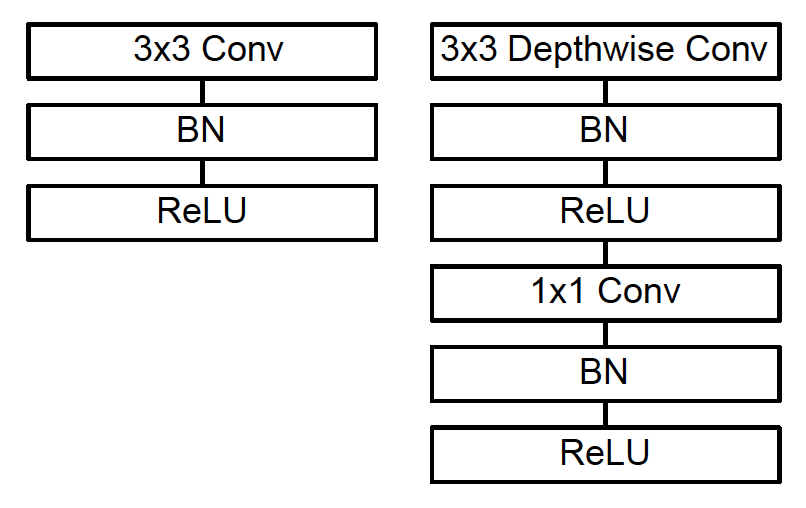

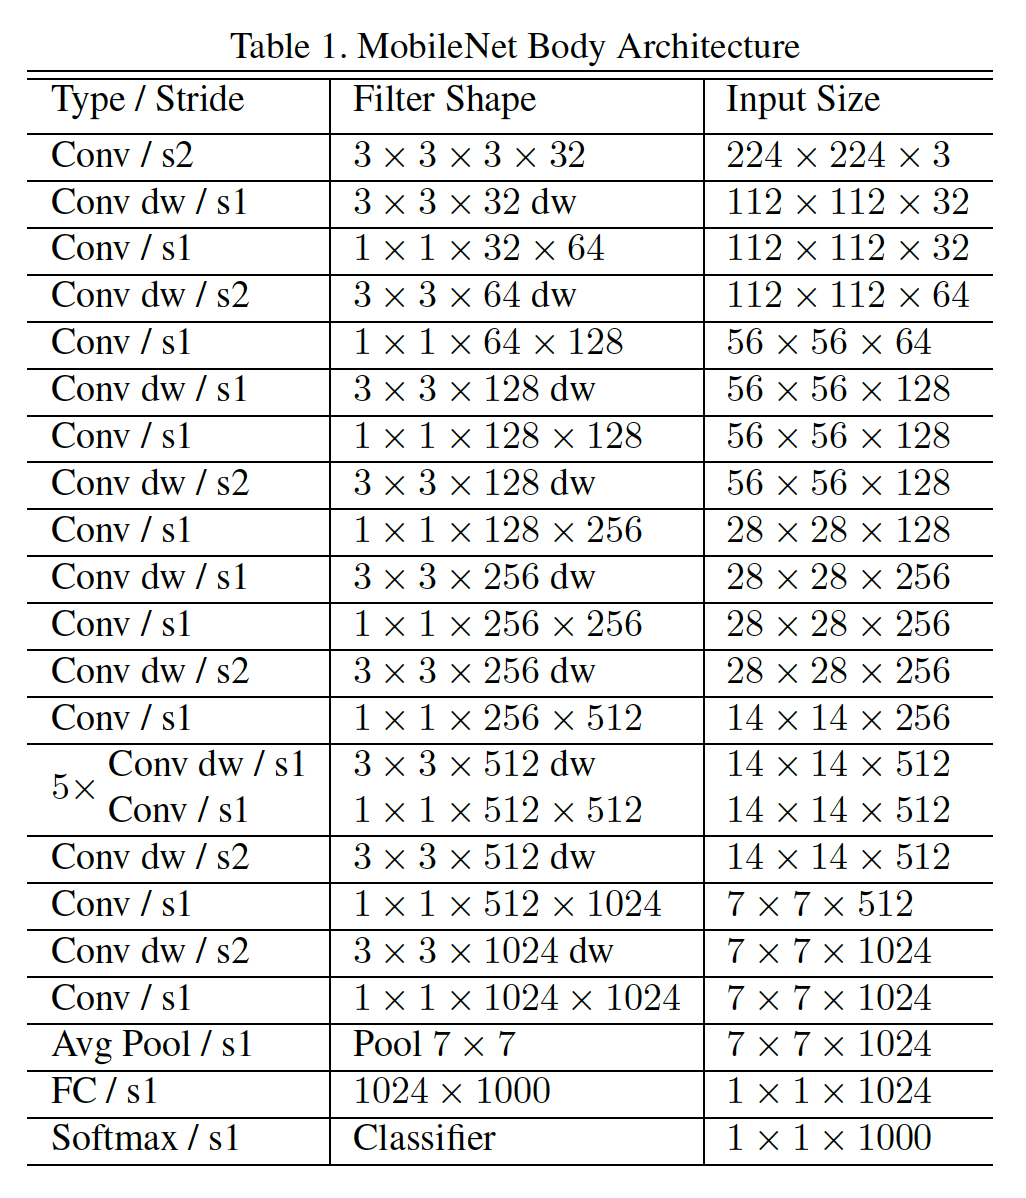

In [0]:
def MobNet (shape, num_classes, alpha=1, ro=1, filter_one=32):

  #alpha should be 1/4, 1/2, 3/4, 1
  #basically between 0 and 1
  #it is a reduce multiplyer of net arcitecture
  #ro is reduce multiplyer of input image
  #also between 0 and 1

  #also additionally we included the number of filters to begin with
  #instead of 32 we can put another minimum 16 and then we grow it like 2**n

  #remember to reshape the image accordingly

  #block that puts batch normalization and relu
  #because we are tired of writing it each time
  def BNR(model):
    model = BN() (model)
    model = ReLU() (model)
    return model

  #standart block
  #you guessed it each convolution is proceeded with
  #batch normalization and linear rectifier relu
  def CBNR(model, filters, kernal, stride=1, padd='same'):
    model = Conv2D (filters, kernal, strides=stride, padding=padd) (model)
    model = BNR(model)
    return model

  #combo block
  #deepwise convolution, in this way we save computational potency
  #instead of one big convolutional block we brake it into two
  #the first one is deepwise second is simple convolution
  #less coeficients appear in this way
  #too bad we did not perserve time to play with permute in all these exercises
  #first convolution as easch convolution in this method
  #is proceeded with batch normalization and relu
  #and standart block inside
  #we mean look at the name
  #it is very self explainatory DCBNRCBNR
  #for those to whom it is hard to read this
  #we put a down underline separator
  def DCBNR_CBNR(model, filters, stride=1, padd='same'):
    model = DepthwiseConv2D(3, strides=stride, padding=padd) (model)
    model = BNR(model)
    model = CBNR(model, filters, 1)
    return model

  #we fill the arcitecture of light net
  def fill(alpha=1, filters=32):
    new_list = []
    if filters<16:
      filters = 32
    if alpha<=0 or 1<alpha:
        alpha=0.5
    for n in range(6):
        new_list.append(int(filters*alpha*2** n))
    return new_list

  if ro<=0 or 1<ro:
    ro=0.5
  tmp=list(int(s*ro) for s in shape[:-1])
  tmp.append(shape[-1])
  shape=tuple(tmp)

  first = Input(shape)
  #arch stends for arcitecture
  arch = fill(alpha, filter_one)
  #it seems like we can imagine a better automatization
  #like one complex cycle
  #because number of filters frows in a simple row a(n)=2^n
  #but at this point we have not figured out it
  #and from another point of view it is more readable
  #and corelates strongly to paper table
  model = CBNR(first, arch[0], 7, 2)
  model = DCBNR_CBNR(model, arch[1])
  model = DCBNR_CBNR(model, arch[2], 2)
  model = DCBNR_CBNR(model, arch[2])
  model = DCBNR_CBNR(model, arch[3], 2)
  model = DCBNR_CBNR(model, arch[3])
  model = DCBNR_CBNR(model, arch[4], 2)
  for _ in range (5):
    model = DCBNR_CBNR(model, arch[4])
  model = DCBNR_CBNR(model, arch[5], 2)
  #this one is strange. in the paper it is said to have stride step 2
  #but the dimentions say it has to have stride = 1
  model = DCBNR_CBNR(model, arch[5])

  #tail
  model = GlobalAveragePooling2D() (model)
  model = Dense(num_classes) (model)
  last = Softmax() (model)
  final = Model(first, last)

  return final

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 112, 112, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 8)         1184      
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 8)         32        
_________________________________________________________________
re_lu_1 (ReLU)               (None, 56, 56, 8)         0         
_________________________________________________________________
depthwise_conv2d_1 (Depthwis (None, 56, 56, 8)         80        
_________________________________________________________________
batch_normalization_2 (Batch (None, 56, 56, 8)         32        
_________________________________________________________________
re_lu_2 (ReLU)               (None, 56, 56, 8)         0   

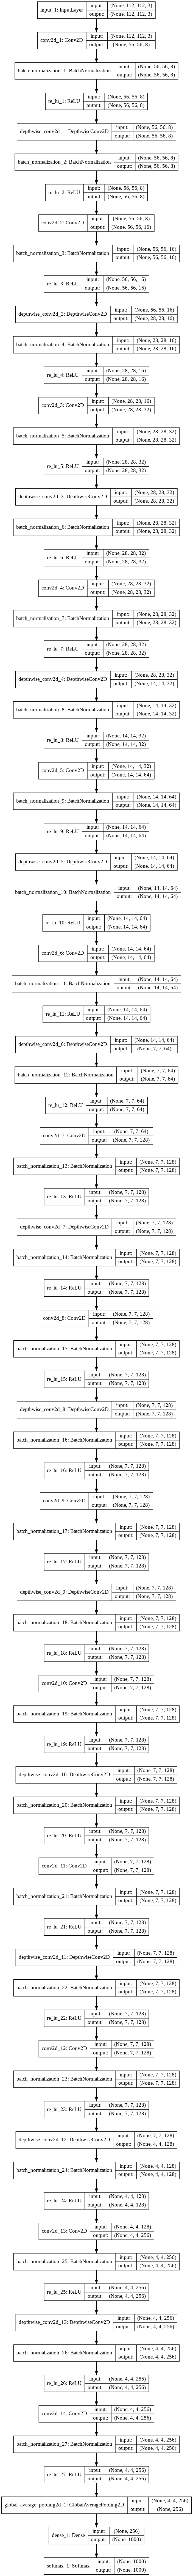

In [0]:
shape = (224, 224, 3)
num_classes = 1000
alpha=0.25
romashka=0.5
BCKN.clear_session()
model = MobNet(shape, num_classes, alpha, romashka)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Mini CNN**

Minimalistic CNN-based ensemble model for gender prediction from face images
Grigory Antipova, Sid-Ahmed Berrania, Jean-Luc Dugelay

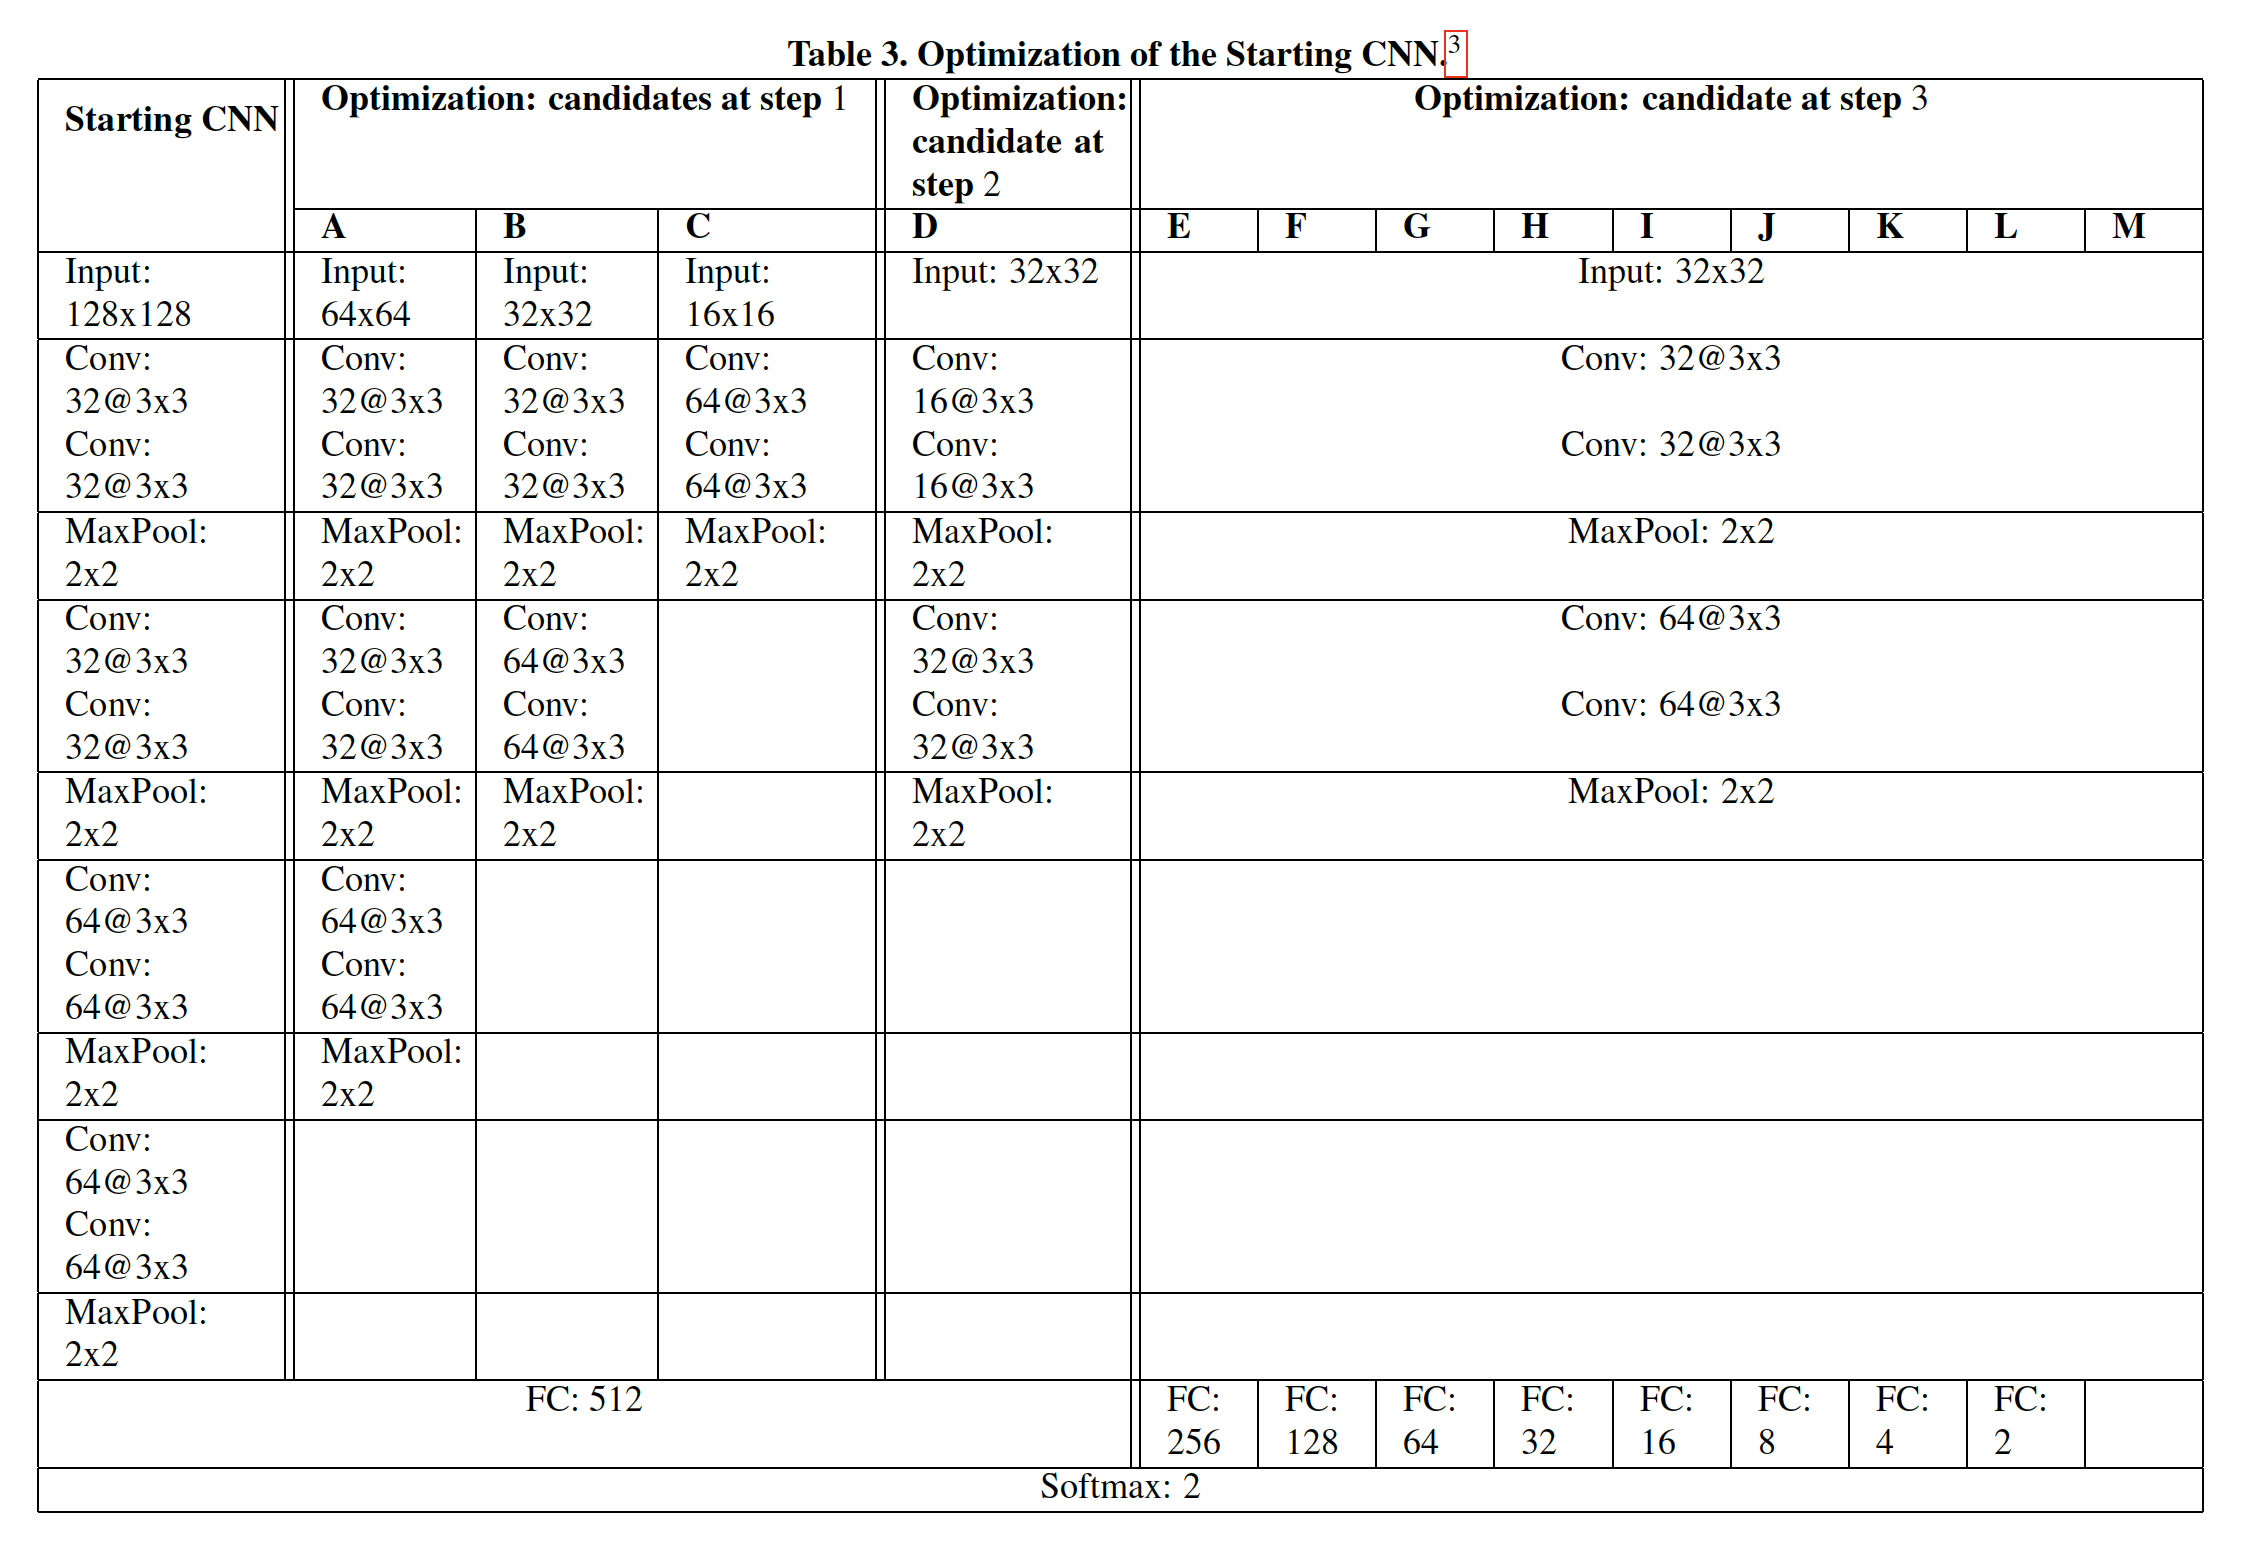

In [0]:
from keras.layers import Dropout, Flatten
from keras.layers import MaxPooling2D

In [0]:
def MCNN (shape, num_classes, arch_list=(0,2,2), FC=512, d=0):

  #these three parameters allow to build any topology from paper
  #sizes of both tuples have to be the same
  #for example if we want E we pass (1,1,0) 512
  #for J we pass (0,1,1) 8
  #by default it is A
  #also we can go outside the given A-M limitation
  #for example mimicing the mobile net we can pass (0,2,1) 4
  #because the biggest number of parameters comes from dense fully connected layer
  #reducing this value we can fil our net into 100k parameters 
  #we can reduce parameters even further with dropout
  sizes = 16, 32, 64

  #convolution relu
  #as paper suggests kernel is always 3
  def CR(model, filters, kernal=3, stride=1, padd='same'):
    model = Conv2D (filters, kernel_size=kernal, strides=stride, padding=padd) (model)
    model = ReLU() (model)
    return model

  #you guessed it: convolution relu convolution relu
  def CRCR(model, filters, kernal=3, stride=1, padd='same'):
    model = CR (model, filters, kernal, stride, padd)
    model = CR (model, filters, kernal, stride, padd)
    return model

  #mini cnn full block
  def MCNNFB (model):
    for s, a in zip(sizes, arch_list):
      for _ in range(a):
        model = CRCR(model, s)
        if d:
          model = Dropout(d) (model)
      model = MaxPooling2D(2) (model)
    return model

  first = Input(shape)
  model = MCNNFB(first)

  #tail
  model = Flatten() (model)
  model = Dense(FC) (model)
  model = ReLU() (model)
  if d:
    model = Dropout(d) (model)
  model = Dense(num_classes) (model)
  last = Softmax() (model)
  final = Model(first, last)

  return final

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
re_lu_12 (ReLU)              (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 50, 50, 32)        9248      
_________________________________________________________________
re_lu_13 (ReLU)              (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 50, 50, 32)        9248

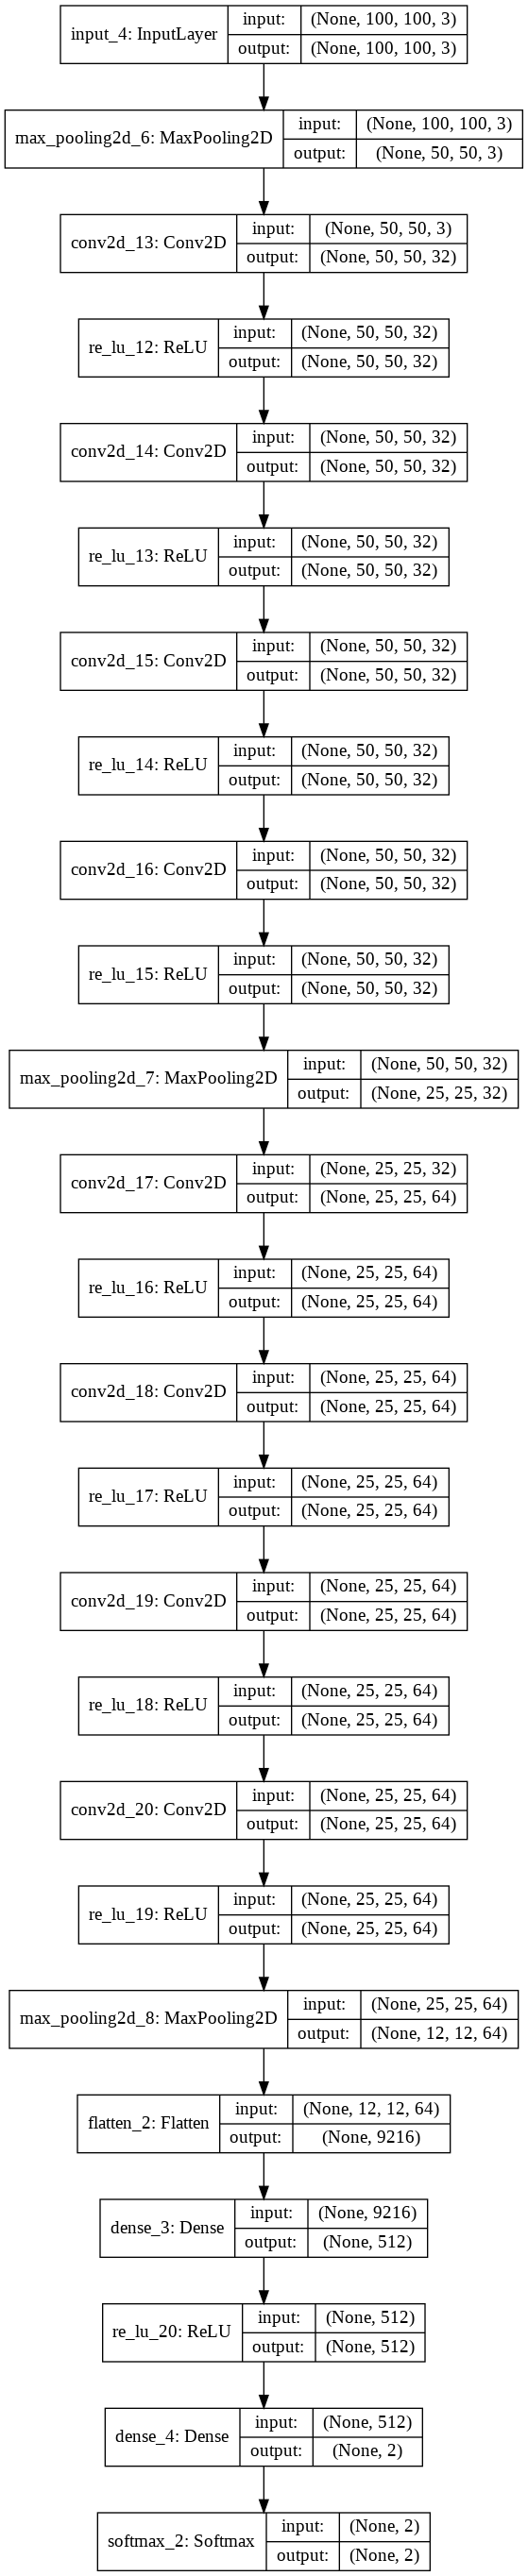

In [0]:
shape = (100, 100, 3)
num_classes = 2
model = MCNN(shape, num_classes)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
#experiment with gender recognition

In [0]:
!wget https://www.dropbox.com/s/zcwlujrtz3izcw8/gender.tgz
!tar xvzf gender.tgz

--2020-05-23 17:29:15--  https://www.dropbox.com/s/zcwlujrtz3izcw8/gender.tgz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/zcwlujrtz3izcw8/gender.tgz [following]
--2020-05-23 17:29:16--  https://www.dropbox.com/s/raw/zcwlujrtz3izcw8/gender.tgz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc082852218816ec9a1e76b07331.dl.dropboxusercontent.com/cd/0/inline/A4QCe9tId4OHvLJf_2x7Oub_2FpgvkrFT3AL-8_hMPd4ea2jFw4Y6d2GodXdWw9-6Ij9HlHbpmLsHVpwX-vgrw3lF_4n23CHXlppe6UrYD2REQ/file# [following]
--2020-05-23 17:29:16--  https://uc082852218816ec9a1e76b07331.dl.dropboxusercontent.com/cd/0/inline/A4QCe9tId4OHvLJf_2x7Oub_2FpgvkrFT3AL-8_hMPd4ea2jFw4Y6d2GodXdWw9-6Ij9HlHbpmLsHVpwX-vgrw3lF_4n23CHXlppe6UrYD2REQ/file
Resolving uc0828522188

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD

from keras.callbacks import LearningRateScheduler as LRS
from keras.preprocessing.image import ImageDataGenerator
import os
import tensorflow as tf

In [0]:
os.system('wget https://www.dropbox.com/s/zcwlujrtz3izcw8/gender.tgz')
os.system('tar xvzf gender.tgz')

0

In [0]:
# Load
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

In [0]:
# Stats
print(x_train.shape)
print(y_train.shape)
print(sum(y_train == 1))
print(sum(y_train == 0))
print("{:.4f}".format(sum(y_train == 1)/y_train.shape[0]))
print(x_test.shape)
print(y_test.shape)
print(sum(y_test == 1))
print(sum(y_test == 0))
print("{:.4f}".format(sum(y_test == 1)/y_test.shape[0]))

(10585, 100, 100, 3)
(10585,)
2381
8204
0.2249
(2648, 100, 100, 3)
(2648,)
596
2052
0.2251


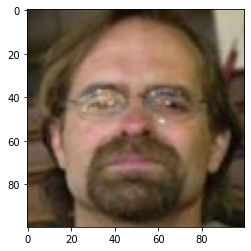

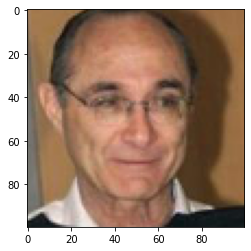

In [0]:
## View some images
plt.imshow(x_train[6969,:,:,: ] )
plt.show()
plt.imshow(x_train[1487,:,:,: ] )
plt.show()

In [0]:
## Transforms
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)


num_classes = 2

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

(10585, 100, 100, 3)
(2648, 100, 100, 3)


In [0]:
mean = np.mean(x_train, axis=(0,1,2,3))
std = np.std(x_train, axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

In [0]:
shape = (100, 100, 3)
num_classes = 2
alpha=0.162
romashka=1
begin = 32
BCKN.clear_session()
model = MobNet(shape, num_classes, alpha, romashka, begin)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 5)         740       
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 5)         20        
_________________________________________________________________
re_lu_1 (ReLU)               (None, 50, 50, 5)         0         
_________________________________________________________________
depthwise_conv2d_1 (Depthwis (None, 50, 50, 5)         50        
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 50, 5)         20        
_________________________________________________________________
re_lu_2 (ReLU)               (None, 50, 50, 5)         0   

In [0]:
## OPTIM AND COMPILE
from keras.optimizers import SGD
opt = SGD(lr=0.01, momentum=0.9)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [0]:
batch_size = 150
num_classes = 2
epochs = 100

# TRAINING
history = model.fit(x_train, y_train,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=(x_test, y_test),
         callbacks = [early_stop]
         )#shuffle=True)

Train on 10585 samples, validate on 2648 samples
Epoch 1/100
10585/10585 [==============================] - 16s 2ms/step - loss: 0.5433 - accuracy: 0.7739 - val_loss: 0.6150 - val_accuracy: 0.7749
Epoch 2/100
10585/10585 [==============================] - 6s 580us/step - loss: 0.5327 - accuracy: 0.7744 - val_loss: 0.5727 - val_accuracy: 0.7749
Epoch 3/100
10585/10585 [==============================] - 6s 576us/step - loss: 0.5173 - accuracy: 0.7729 - val_loss: 0.5370 - val_accuracy: 0.7749
Epoch 4/100
10585/10585 [==============================] - 6s 581us/step - loss: 0.4997 - accuracy: 0.7782 - val_loss: 0.5334 - val_accuracy: 0.7749
Epoch 5/100
10585/10585 [==============================] - 6s 579us/step - loss: 0.4419 - accuracy: 0.8094 - val_loss: 0.5496 - val_accuracy: 0.7749
Epoch 6/100
10585/10585 [==============================] - 6s 577us/step - loss: 0.3890 - accuracy: 0.8358 - val_loss: 0.4891 - val_accuracy: 0.7764
Epoch 7/100
10585/10585 [==============================] -

In [0]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

2648/2648 [==============================] - 1s 285us/step
Test loss: 0.4097298141709582
Test accuracy: 0.9048338532447815


In [0]:
shape = (100, 100, 3)
num_classes = 2
alpha=0.5
romashka=1
begin = 64
BCKN.clear_session()
model = MobNet(shape, num_classes, alpha, romashka, begin)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4736      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 50, 50, 32)        0         
_________________________________________________________________
depthwise_conv2d_1 (Depthwis (None, 50, 50, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 50, 50, 32)        0   

In [0]:
from keras.optimizers import SGD
opt = SGD(lr=0.01, momentum=0.9)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [0]:
batch_size = 128
num_classes = 2
epochs = 50

# TRAINING
history = model.fit(x_train, y_train,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=(x_test, y_test),
         callbacks = [early_stop]
         )#shuffle=True)

Train on 10585 samples, validate on 2648 samples
Epoch 1/50
10585/10585 [==============================] - 21s 2ms/step - loss: 0.3038 - accuracy: 0.8911 - val_loss: 17.1750 - val_accuracy: 0.7749
Epoch 2/50
10585/10585 [==============================] - 17s 2ms/step - loss: 0.2120 - accuracy: 0.9147 - val_loss: 0.9527 - val_accuracy: 0.7844
Epoch 3/50
10585/10585 [==============================] - 17s 2ms/step - loss: 0.1505 - accuracy: 0.9391 - val_loss: 0.2934 - val_accuracy: 0.8818
Epoch 4/50
10585/10585 [==============================] - 17s 2ms/step - loss: 0.1079 - accuracy: 0.9594 - val_loss: 0.2855 - val_accuracy: 0.8958
Epoch 5/50
10585/10585 [==============================] - 17s 2ms/step - loss: 0.1079 - accuracy: 0.9577 - val_loss: 0.5083 - val_accuracy: 0.8591
Epoch 6/50
10585/10585 [==============================] - 17s 2ms/step - loss: 0.0760 - accuracy: 0.9698 - val_loss: 0.3038 - val_accuracy: 0.9120
Epoch 7/50
10585/10585 [==============================] - 17s 2ms/st

In [0]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

2648/2648 [==============================] - 1s 538us/step
Test loss: 0.28916133081375517
Test accuracy: 0.9410876035690308


In [0]:
## OPTIM AND COMPILE
from keras.optimizers import SGD
opt = SGD(lr=0.01, momentum=0.9)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [0]:
batch_size = 128
num_classes = 2
epochs = 50

# TRAINING
history = model.fit(x_train, y_train,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=(x_test, y_test),
         callbacks = [early_stop]
         )#shuffle=True)

Train on 10585 samples, validate on 2648 samples
Epoch 1/50
10585/10585 [==============================] - 10s 952us/step - loss: 0.5174 - accuracy: 0.7782 - val_loss: 0.4504 - val_accuracy: 0.8059
Epoch 2/50
10585/10585 [==============================] - 4s 341us/step - loss: 0.4037 - accuracy: 0.8191 - val_loss: 0.2961 - val_accuracy: 0.8818
Epoch 3/50
10585/10585 [==============================] - 4s 341us/step - loss: 0.2585 - accuracy: 0.8955 - val_loss: 0.1842 - val_accuracy: 0.9248
Epoch 4/50
10585/10585 [==============================] - 4s 341us/step - loss: 0.1887 - accuracy: 0.9265 - val_loss: 0.1523 - val_accuracy: 0.9437
Epoch 5/50
10585/10585 [==============================] - 4s 344us/step - loss: 0.1633 - accuracy: 0.9370 - val_loss: 0.1342 - val_accuracy: 0.9562
Epoch 6/50
10585/10585 [==============================] - 4s 341us/step - loss: 0.1375 - accuracy: 0.9495 - val_loss: 0.1407 - val_accuracy: 0.9490
Epoch 7/50
10585/10585 [==============================] - 4s 3

In [0]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

2648/2648 [==============================] - 1s 238us/step
Test loss: 0.2961647459255344
Test accuracy: 0.9611027240753174
